# Part 3 : Can we predict employee churn uing deep learning ?

After reading this article(https://towardsdatascience.com/building-an-employee-churn-model-in-python-to-develop-a-strategic-retention-plan-57d5bd882c2d), i was using the same dataset to verify potential added values using more advanced approach. 

## Overview:
Dataset is unbalanced, this is not ideal for a deep learning approach.
To solve this potential issue, i use oversampling technique using SMOTE.
Then, i simply follow regular canevas described in the lesson 4 of the FastAI course v3.

## Related work:
Part 1 : Can we identify most important features using LOFO ?

Part 2 : What would be the the best traditional modeling approach ?

Part 3 : Can we predict employee churn uing deep learning ?

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # drawing graph
import warnings; warnings.filterwarnings("ignore") 
import os; os.environ['OMP_NUM_THREADS'] = '4' # speed up using 4 cpu
from fastai.tabular import *
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [2]:
def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

In [3]:
dtypes={
    'Age':                         'int64',
    'Attrition':                   'category',
    'BusinessTravel':              'category',
    'DailyRate':                   'int64',
    'Department':                  'category',
    'DistanceFromHome':            'int64',
    'Education':                   'int64',
    'EducationField':              'category',
    'EmployeeCount':               'int64',
    'EmployeeNumber':              'int64',
    'EnvironmentSatisfaction':     'int64',
    'Gender':                      'category',
    'HourlyRate':                  'int64',
    'JobInvolvement':              'int64',
    'JobLevel':                    'int64',
    'JobRole':                     'category',
    'JobSatisfaction':             'int64',
    'MaritalStatus':               'category',
    'MonthlyIncome':               'int64',
    'MonthlyRate':                 'int64',
    'NumCompaniesWorked':          'int64',
    'Over18':                      'category',
    'OverTime':                    'category',
    'PercentSalaryHike':           'int64',
    'PerformanceRating':           'int64',
    'RelationshipSatisfaction':    'int64',
    'StandardHours':               'int64',
    'StockOptionLevel':            'int64',
    'TotalWorkingYears':           'int64',
    'TrainingTimesLastYear':       'int64',
    'WorkLifeBalance':             'int64',
    'YearsAtCompany':              'int64',
    'YearsInCurrentRole':          'int64',
    'YearsSinceLastPromotion':     'int64',
    'YearsWithCurrManager':        'int64',}

In [4]:
# source : https://www.ibm.com/communities/analytics/watson-analytics-blog/hr-employee-attrition/
df = pd.read_excel('../input/WA_Fn-UseC_-HR-Employee-Attrition.xlsx', sheet_name=0,dtype=dtypes)
print("Shape of dataframe is: {}".format(df.shape))

Shape of dataframe is: (1470, 35)


In [5]:
# preprocessing : categorical encoding
df['Attrition']=df.Attrition.eq('Yes').mul(1) # change target from Yes/no to 1/0
cont=[]
cat=[]
for key, value in dtypes.items():
    if key!='Attrition':
        if value == "int64":
            cont.append(key)
        else:
            cat.append(key)
df = pd.get_dummies(df, columns=cat)

In [6]:
# get train data
col = df.columns
cont=[]
for i in range(0,len(col)):
    if col[i]!='Attrition':
        cont.append(col[i])

In [7]:
#save the column name
x_col = cont
y_col = 'Attrition'

X = df.drop('Attrition', axis=1)
Y = df.Attrition
X_res, Y_res = SMOTE().fit_resample(X, Y)

In [8]:
smote_df = pd.DataFrame(X_res, columns = x_col)

In [9]:
smote_df = smote_df.assign(Attrition = Y_res)

In [10]:
smote_df.Attrition.value_counts()

1    1233
0    1233
Name: Attrition, dtype: int64

In [11]:
smote_df.shape

(2466, 56)

In [12]:
dep_var='Attrition'
procs=[ Normalize]
data = (TabularList.from_df(smote_df, cont_names=col , procs=procs,)
                .split_subsets(train_size=0.8, valid_size=0.2, seed=34)
                .label_from_df(cols=dep_var)
                .databunch())

In [13]:
learn = tabular_learner(data, layers=[200,100],metrics=accuracy, callback_fns=AUROC)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03


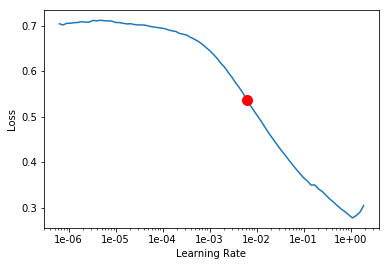

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [15]:
learn.fit(3,lr=1e-3)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.233501,0.144441,0.987830,0.999951,00:00
1,0.103391,0.014968,1.000000,1.000000,00:00
2,0.051696,0.005557,1.000000,1.000000,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06


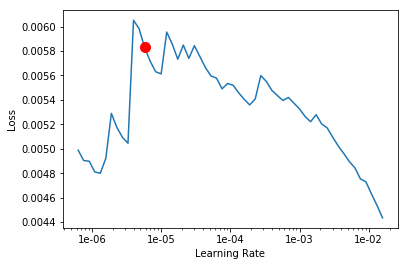

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [17]:
learn.fit_one_cycle(2,max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.005414,0.005653,1.000000,1.000000,00:00
1,0.005207,0.006084,1.000000,1.000000,00:00


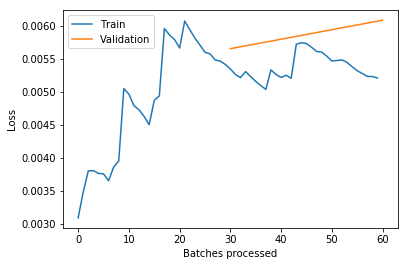

In [18]:
learn.recorder.plot_losses()

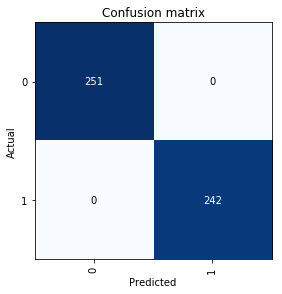

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()